# 1) Install/Import packages

In [6]:
!pip install numpy shapely matplotlib pandas aif360 plotly scikit-learn catboost pytorch_tabnet xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 7.3/150.0 MB 41.2 MB/s eta 0:00:04
   --- ------------------------------------ 14.7/150.0 MB 36.9 MB/s eta 0:00:04
   ----- ---------------------------------- 21.8/150.0 MB 35.2 MB/s eta 0:00:04
   ------ --------------------------------- 25.4/150.0 MB 32.2 MB/s eta 0:00:04
   -------- ------------------------------- 30.1/150.0 MB 29.9 MB/s eta 0:00:05
   --------- ------------------------------ 37.2/150.0 MB 30.3 MB/s eta 0:00:04
   ----------- ---------------------------- 44.8/150.0 MB 31.0 MB/s eta 0:00:04
   ------------- -------------------------- 51.9/150.0 MB 31.5 MB/s eta 0:00:04
   --------------- ------------------------ 59.2/150.0 MB 31.7 MB/s eta 0:00:03
   ----------------- ---------------------- 66.6/150.0 MB 32.1 MB/s eta 0:00:03
   ------------------- -------------------- 73.4/150.0 MB 32.3 MB/s eta 0:00:03
   --------------------- ------------------ 80.7/1

In [7]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from Fairea.fairea import create_baseline,normalize,classify_region,compute_area
from shapely.geometry import Polygon, Point, LineString
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 12})
import pandas as pd
from aif360.datasets import BinaryLabelDataset

# 2) Generate baseline

To evaluate bias mitigation methods using the FAIREA approach, the first step is to generate a baseline that represents the trade-off between fairness and accuracy for naive solutions.

In [8]:
dataset_used = "diabetes"
clf_name = "dt"

degrees = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
mutation_strategies = {"0":[1,0],"1":[0,1]}

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

label_name = 'readmitted'
sensitive_attribute = ['gender_race']

privileged_groups = [{'gender_race': 1}]
unprivileged_groups = [{'gender_race': 0}]

data = pd.read_csv('../data/diabetes_pre/diabetes.csv')

dataset_orig = BinaryLabelDataset(
    df=data,
    label_names=[label_name],
    protected_attribute_names = sensitive_attribute,
    favorable_label = 1,
    unfavorable_label = 0
)

In [9]:
res = create_baseline(clf_name,dataset_orig, privileged_groups,unprivileged_groups,
                    data_splits=10,repetitions=10,odds=mutation_strategies,options = [0,1],
                   degrees = degrees)

Obtain accuray (index 0 of each row) and fairness (SPD is index 1, AOD is index 2, CFS is index 3) for each overwriting strategy

In [10]:
acc0 = np.array([np.mean([row[0] for row in res["0"][degree]]) for degree in degrees])
acc1 = np.array([np.mean([row[0] for row in res["1"][degree]]) for degree in degrees])

spd0 = np.array([np.mean([row[3] for row in res["0"][degree]]) for degree in degrees])
spd1 = np.array([np.mean([row[3] for row in res["1"][degree]]) for degree in degrees])

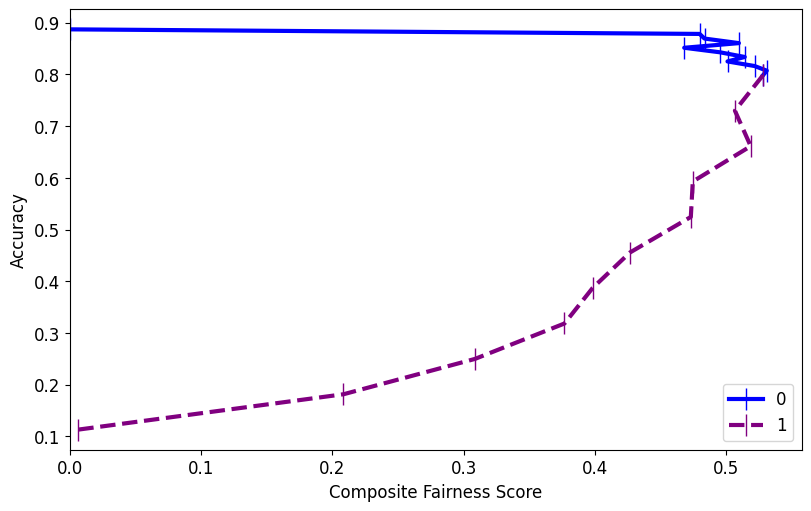

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5),constrained_layout=True)
axes.plot(spd0,acc0,color="blue",marker = "|", linestyle = "solid",linewidth=3,markersize=16)
axes.plot(spd1,acc1,color="purple",marker = "|", linestyle = "dashed",linewidth=3,markersize=16)
axes.set_xlim(0)
axes.set_xlabel("Composite Fairness Score")
axes.set_ylabel("Accuracy")
axes.legend(mutation_strategies.keys())

Among those two strategies, "0" is the stricter (higher accuracy for identical value of CFS) and will be used in the following

# 3) Determine mitigation region
To determine the mitigation region of bias mitigation methods, we perform three steps:

1. Normalize the data
2. Determine region
3. Compute area of "good trade-off region"

In [6]:
import pandas as pd
df = pd.read_csv('../f_results/diabetes_small.csv')
df.head()

,model,BM,balanced_acc,acc,precision,recall,f1,eq_opp_diff,avg_odd_diff,spd,disparate_impact,theil_idx,fair_score
0,AD,preR inAD posE,0.560376,0.485661,0.134130,0.656716,0.222762,-0.323963,-0.191426,-0.081690,0.851412,0.096177,0.853
1,AD,preR inAD posR,0.504293,0.883811,0.229358,0.014925,0.028027,-0.014952,-0.010657,-0.007327,0.000000,0.119573,0.627
2,TabNetClassifier,baseline,0.604327,0.628518,0.165832,0.573134,0.257235,0.093700,0.057828,0.016408,1.042306,0.108168,0.207
3,AD,inAD posC,0.528638,0.203364,0.118596,0.948060,0.210820,0.052033,0.080807,0.103112,1.114967,0.034771,0.384
4,AD,inAD posE,0.579374,0.649960,0.157763,0.488358,0.238484,-0.489234,-0.398570,-0.327181,0.061059,0.117186,1.000


[1.         0.9590613  0.98204981 0.89758621 0.89471264 0.80586207
 0.75153257 0.7104023  0.57975096 0.38793103 0.        ]
[1.         0.90001368 0.79993698 0.70012116 0.60019494 0.49984659
 0.39998534 0.29965996 0.19967706 0.0999829  0.        ]


Text(0, 0.5, 'Accuracy')

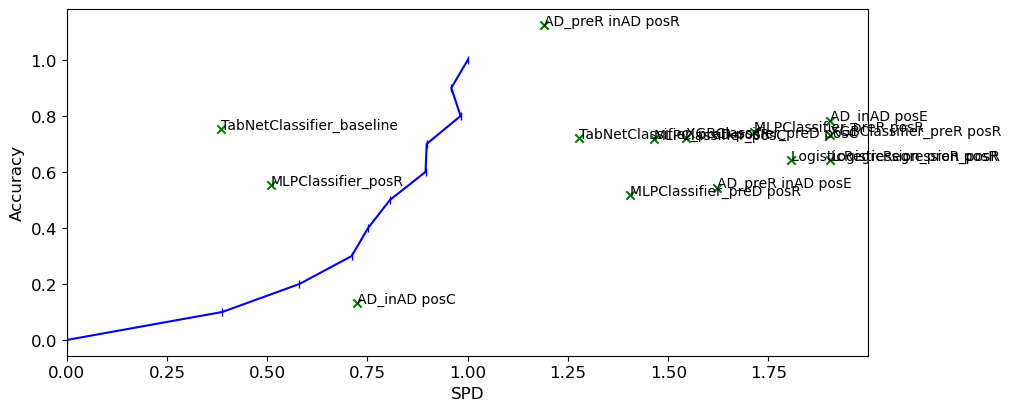

In [7]:
key_list = df.model.str.cat(df.BM, sep='_').to_list()
acc_list, fair_list = df.acc.to_list(), df.fair_score.to_list()
methods = {key: (float(val1), float(val2)) for key, val1, val2 in zip(key_list, acc_list, fair_list)}

normalized_accuracy, normalized_fairness, normalized_methods = normalize(acc1,spd1,methods)

print(normalized_fairness)
print(normalized_accuracy)


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4),constrained_layout=True)
axes.plot(normalized_fairness, normalized_accuracy,color="blue",marker = "|")

axes.scatter([x[1] for x in normalized_methods.values()],[x[0] for x in normalized_methods.values()],marker="x",color="green")
for k,v in normalized_methods.items():
    axes.annotate(k, (v[1], v[0]), fontsize=10)
axes.set_xlim(0)
axes.set_xlabel("SPD")
axes.set_ylabel("Accuracy")
#plt.show()

# 4) Display bias mitigation methods

We use experimental data from bias mitigation methods generated with the callmefair framework. For each bias mitigation method, "data" reports accuracy and CPS averaged over multiple different data splits.

In [8]:
from shapely.geometry import Polygon, Point, LineString
%matplotlib inline
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 12})


In [9]:
x_th = max([min(acc0), min(acc1)])
y_th = min([max(spd0), max(spd1)])

def plot_tradeoff(df, x_split=x_th, y_split=y_th, diagonal_end=None,
                 region_colors=None, title="Accuracy vs Bias Trade-off Regions"):
    """
    Creates a trade-off plot with dynamic ranges and configurable regions
    """
    # Calculate dynamic ranges with 5% padding
    x_min = max(0, df['fair_score'].min() - 0.05)
    x_max = min(1, df['fair_score'].max() + 0.05)
    y_min = max(0, df['acc'].min() - 0.05)
    y_max = min(1, df['acc'].max() + 0.05)

    # Set default diagonal end if not provided
    if diagonal_end is None:
        diagonal_end = (x_split, y_max)

    # Default colors with high transparency
    colors = {
        'win_win': 'rgba(0,200,0,0.1)',
        'good_tradeoff': 'rgba(100,200,100,0.1)',
        'poor_tradeoff': 'rgba(255,165,0,0.1)',
        'inverted': 'rgba(128,0,128,0.1)',
        'lose_lose': 'rgba(255,0,0,0.1)'
    }
    if region_colors:
        colors.update(region_colors)

    fig = go.Figure()

    # Region coordinates
    left_regions = {
        'base_x': x_min,
        'base_y': y_min,
        'split_x': x_split,
        'split_y': y_split,
        'diag_x': diagonal_end[0],
        'diag_y': diagonal_end[1]
    }

    # Add regions (order matters for layering)
    # Poor Trade-off (rectangle)
    fig.add_shape(type="rect",
        x0=left_regions['base_x'], y0=left_regions['base_y'],
        x1=left_regions['split_x'], y1=left_regions['split_y'],
        fillcolor=colors['poor_tradeoff'], layer="below")

    # Good Trade-off (triangle)
    fig.add_shape(type="path",
        path=f"M {left_regions['base_x']} {left_regions['split_y']} "
             f"L {left_regions['diag_x']} {left_regions['diag_y']} "
             f"L {left_regions['split_x']} {left_regions['split_y']} Z",
        fillcolor=colors['good_tradeoff'], layer="below")

    # Win-Win (triangle)
    fig.add_shape(type="path",
        path=f"M {left_regions['base_x']} {left_regions['split_y']} "
             f"L {left_regions['diag_x']} {left_regions['diag_y']} "
             f"L {left_regions['base_x']} {left_regions['diag_y']} Z",
        fillcolor=colors['win_win'], layer="below")

    # Right regions
    fig.add_shape(type="rect", x0=x_split, y0=y_split, x1=x_max, y1=y_max,
                 fillcolor=colors['inverted'], layer="below")
    fig.add_shape(type="rect", x0=x_split, y0=y_min, x1=x_max, y1=y_split,
                 fillcolor=colors['lose_lose'], layer="below")

    # Add scatter plot
    fig.add_trace(go.Scatter(
        x=df['fair_score'], y=df['acc'],
        mode='markers', marker=dict(size=10, color='blue'),
        name='Models'))

    # Adjusted annotations
    annotations = [
        dict(x=(x_min + x_split)/2, y=.01+(y_split + y_max)/2,
             text="Win-Win", showarrow=False, font=dict(color='darkgreen')),
        dict(x=(x_min + x_split)/2, 
             y=y_split + (left_regions['diag_y'] - y_split)*0.3,  # Adjusted position
             text="Good Trade-off", showarrow=False, font=dict(color='green')),
        dict(x=(x_min + x_split)/2, y=y_min + (y_split - y_min)/2,
             text="Poor Trade-off", showarrow=False, font=dict(color='darkorange')),
        dict(x=(x_split + x_max)/2, y=(y_split + y_max)/2,
             text="Inverted", showarrow=False, font=dict(color='purple')),
        dict(x=(x_split + x_max)/2, y=y_min + (y_split - y_min)/2,
             text="Lose-Lose", showarrow=False, font=dict(color='darkred'))
    ]
    # Find the point with the lowest fairness score
    min_fair_score_row = df.loc[df['fair_score'].idxmin()]
    min_fair_score = min_fair_score_row['fair_score']
    max_acc = min_fair_score_row['acc']
    bm_technique = min_fair_score_row['BM']
    model = min_fair_score_row['model']

    # Highlight the point with the lowest fairness score
    fig.add_trace(
        go.Scatter(
            x=[min_fair_score],
            y=[max_acc],
            mode='markers',
            marker=dict(size=15, color='red', symbol='star',line=dict(width=2,color='DarkSlateGrey')),
            name=f"Best Fairness<br>Model: {model}<br>BM: {bm_technique}",
            showlegend=True
        )
    )

    # Find the point with the highest accuracy score
    max_acc_row = df.loc[df['acc'].idxmax()]
    max_fair_score = max_acc_row['fair_score']
    max_acc = max_acc_row['acc']
    bm_technique = max_acc_row['BM']
    model = max_acc_row['model']

    # Highlight the point with the highest acc score
    fig.add_trace(
        go.Scatter(
            x=[max_fair_score],
            y=[max_acc],
            mode='markers',
            marker=dict(size=15, color='green', symbol='star', line=dict(width=2,color='DarkSlateGrey')),
            name=f"Best Accuracy<br>Model: {model}<br>BM: {bm_technique}",
            showlegend=True
        )
    )

    fig.update_layout(
        title=title,
        xaxis_title="Fair Score",
        yaxis_title="Accuracy",
        xaxis=dict(range=[x_min - 0.05, x_max + 0.05]),
        yaxis=dict(range=[y_min - 0.05, y_max + 0.05]),
        annotations=annotations,
        showlegend=True,
        plot_bgcolor='white',
    )

    return fig

fig = plot_tradeoff(df)
fig.show()

## 4-2) Mitigation Region

In [10]:
# Transform baseline to geometric shape with shapely
baseline = LineString([(x,y) for x, y in zip(normalized_fairness,normalized_accuracy)])
regions = classify_region(baseline, normalized_methods)
regions

{'AD_preR inAD posE': 'lose-lose',
 'AD_preR inAD posR': 'inverted',
 'TabNetClassifier_baseline': 'good trade-off',
 'AD_inAD posC': 'bad trade-off',
 'AD_inAD posE': 'lose-lose',
 'TabNetClassifier_preD posR': 'lose-lose',
 'XGBClassifier_preR posR': 'lose-lose',
 'XGBClassifier_preD posC': 'lose-lose',
 'MLPClassifier_preR posR': 'lose-lose',
 'MLPClassifier_preD posR': 'lose-lose',
 'LogisticRegression_posR': 'lose-lose',
 'LogisticRegression_preR posR': 'lose-lose',
 'MLPClassifier_posC': 'lose-lose',
 'MLPClassifier_posR': 'good trade-off'}

## 4-3) Determine area
Before determining the area, we filter methods for the "good trade-off" region

In [11]:
good = {k for k,v in regions.items() if v == "good trade-off"}
normalized_methods = {k:v for k,v in normalized_methods.items() if k in good}
good,normalized_methods

({'MLPClassifier_posR', 'TabNetClassifier_baseline'},
 {'TabNetClassifier_baseline': (0.7521460228722744, 0.3850574712643678),
  'MLPClassifier_posR': (0.5537885789535912, 0.5095785440613027)})

In [12]:
for k,v in normalized_methods.items():
    area = compute_area(baseline,v)
    print (k,area)

TabNetClassifier_baseline 0.23542551456260435
MLPClassifier_posR 0.08118286154269606
